In [1]:
import tensorflow.compat.v1 as tf1
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "1"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.03
session = tf1.Session(config=config)

2023-02-27 04:37:04.507033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 04:37:04.615465: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-27 04:37:04.643734: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-27 04:37:05.235322: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchsummary import summary
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
import torchvision

In [8]:
path = './jk/'
burnData = glob.glob(path + 'burn*.jpg')
woundData = glob.glob(path + 'wound*.jpg')

burnTrain = []
burnVal = []
burnTest = []
woundTrain = []
woundVal = []
woundTest = []

# print(len(burnData))
# print(len(woundData))
for i in range(3500):
    random_num1 = random.choice(burnData)
    burnTrain.append(random_num1)
    burnData.remove(random_num1)

    random_num2 = random.choice(woundData)
    woundTrain.append(random_num2)
    woundData.remove(random_num2)
    
    
    
for j in range(1000):
    random_num1 = random.choice(burnData)
    burnVal.append(random_num1)
    burnData.remove(random_num1)
    
    random_num2 = random.choice(woundData)
    woundVal.append(random_num2)
    woundData.remove(random_num2)
    
burnTest = burnData.copy()
woundTest = woundData.copy()

trainData = burnTrain + woundTrain
testData = burnTest + woundTest
validData = burnVal + woundVal

In [9]:
class CustomDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.transform = transforms.ToTensor()
        
    def __getitem__(self, index):
        data_dir = self.data_dir
        x_data = Image.open(data_dir[index])
        x_data = self.transform(x_data)
        
        y_data = 1 if "burn" in data_dir[index] else 0
        
#         sample = {'image': x_data, 'label': y_data}
        return x_data, y_data
    
    def __len__(self):
        return len(self.data_dir)

In [10]:
train_dataset = CustomDataset(trainData)
test_dataset = CustomDataset(testData)
valid_dataset = CustomDataset(validData)

In [11]:
train_loader = DataLoader(train_dataset, batch_size = 10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 10, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = 10, shuffle=True)

## DataLoader가 제대로 작동하는지 확인

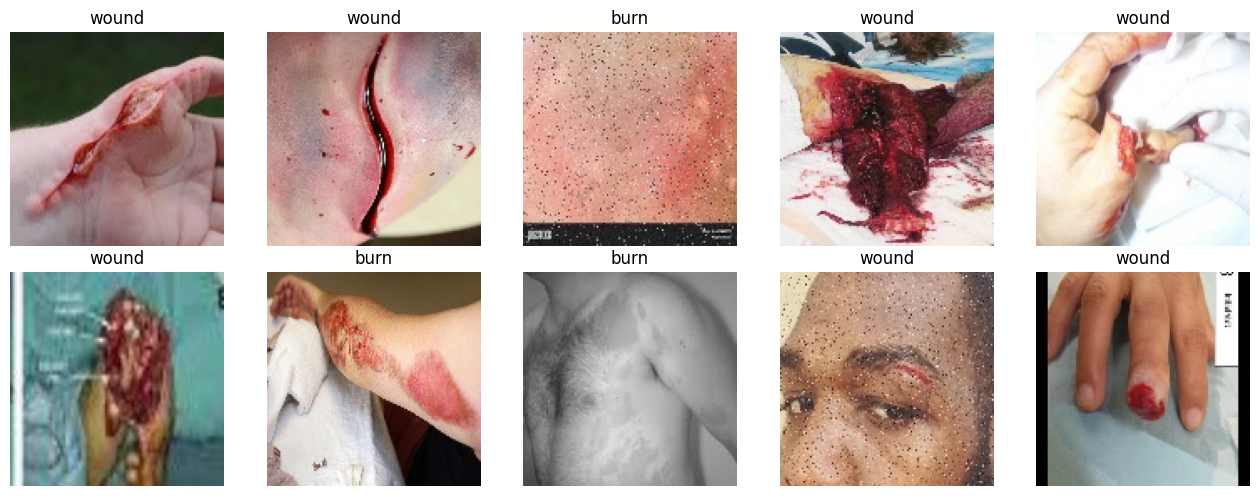

In [31]:
samples, labels = next(iter(train_loader))
classes = {0: 'wound', 1:'burn'}
fig = plt.figure(figsize=(16,12))
for i in range(10):
    a = fig.add_subplot(2,5,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

### gpu사용 및 resnet 모델

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [18]:
model = torchvision.models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jaekang/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
import torch.nn as nn
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

In [22]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
model.cuda()
summary(model, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training

In [56]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            pred = pred.view(-1)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()
            
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                pred = pred.view(-1)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
        
        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)
        
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
        
    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend() 
    plt.title('train loss and accuracy')
    plt.show()
    
    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend() 
    plt.title('valid loss and accuracy')
    plt.show()

42.824sec : [Epoch 1/10] -> train loss: 0.0307, train acc: 99.671% / valid loss: 0.1502, valid acc: 95.950%
42.378sec : [Epoch 2/10] -> train loss: 0.0928, train acc: 99.529% / valid loss: 0.1172, valid acc: 96.600%
42.816sec : [Epoch 3/10] -> train loss: 0.0564, train acc: 99.457% / valid loss: 0.1326, valid acc: 96.150%
43.125sec : [Epoch 4/10] -> train loss: 0.0191, train acc: 99.657% / valid loss: 0.0995, valid acc: 96.600%
42.985sec : [Epoch 5/10] -> train loss: 0.0080, train acc: 99.671% / valid loss: 0.0895, valid acc: 96.600%
42.641sec : [Epoch 6/10] -> train loss: 0.0107, train acc: 99.743% / valid loss: 0.0974, valid acc: 96.850%
42.890sec : [Epoch 7/10] -> train loss: 0.0083, train acc: 99.743% / valid loss: 0.1564, valid acc: 96.650%
43.227sec : [Epoch 8/10] -> train loss: 0.0061, train acc: 99.857% / valid loss: 0.1267, valid acc: 96.650%
42.611sec : [Epoch 9/10] -> train loss: 0.0051, train acc: 99.814% / valid loss: 0.1077, valid acc: 97.000%
42.963sec : [Epoch 10/10] ->

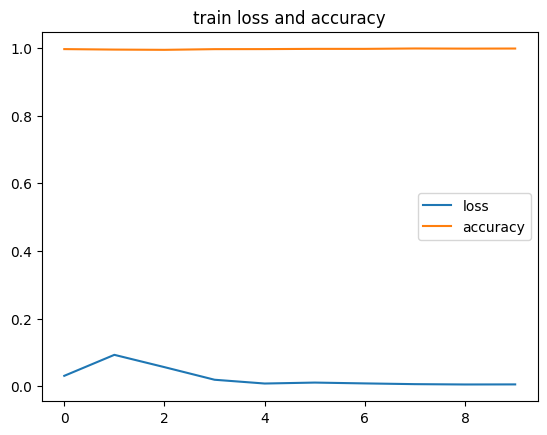

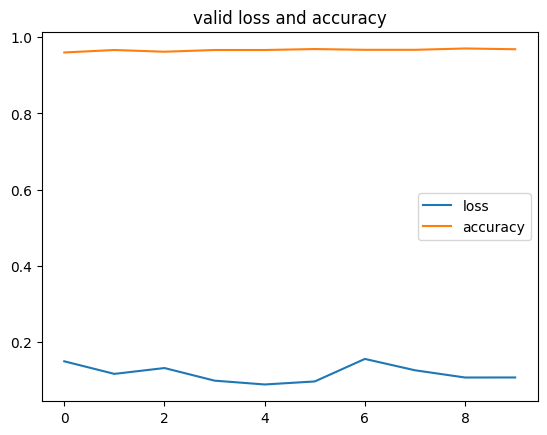

In [57]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

fit(model,criterion, optimizer, 10, train_loader, valid_loader)

## 모델 평가

In [58]:
def eval(model, criterion, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        losses = 0
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            pred = pred.view(-1)
            loss = criterion(pred, test_y)
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            
            losses += loss.item()
            correct += y_pred.eq(test_y.cpu()).int().sum()
            
    print(f'eval loss: {losses/len(test_loader):.4f}, eval acc: {correct/len(test_loader.dataset)*100:.3f}%')

In [60]:
eval(model, criterion, test_loader)

eval loss: 0.2438, eval acc: 96.900%


In [62]:
torch.save(model.state_dict(), './injurymodel1.pth')

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(42050, 500)
        self.fc2 = nn.Linear(500, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1) # [batch_size, 50, 4, 4]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
cnn = CNN()
criterion = nn.BCEWithLogitsLoss
optimizer = optim.SGD(cnn.parameters(), lr=0.01)